In [58]:
import os
import re
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler ,RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import experimental as exp_opt
import random


# 루트 디렉토리 경로 (뉴스 파일 위치)
ROOT_DIR = "./news_data"   
WINDOW = 7
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)


# 날짜 파싱 함수
def parse_date_from_filename(filename):
    patterns = [
        r'(\d{4})-(\d{2})-(\d{2})',
        r'(\d{4})(\d{2})(\d{2})',
        r'(\d{2})-(\d{2})-(\d{4})',
        r'(\d{2})(\d{2})(\d{4})'
    ]
    basename = os.path.basename(filename)
    for pattern in patterns:
        match = re.search(pattern, basename)
        if match:
            try:
                if len(match.group(1)) == 4:
                    year, month, day = match.groups()
                else:
                    day, month, year = match.groups()
                return pd.to_datetime(f"{year}-{month}-{day}")
            except:
                continue
    return None

# 뉴스 데이터 로드 함수
def load_all_news_data(root_dir):
    all_data = []
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"디렉토리가 존재하지 않습니다: {root_dir}")
    csv_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.csv')])
    for filename in csv_files:
        filepath = os.path.join(root_dir, filename)
        file_date = parse_date_from_filename(filename)
        for enc in ['utf-8', 'cp949', 'latin1']:
            try:
                df = pd.read_csv(filepath, encoding=enc)
                break
            except UnicodeDecodeError:
                continue
        else:
            print(f"읽기 실패: {filepath}")
            continue
        df = df.loc[:,['news','label'] if 'date' not in df.columns else ['news','label','date']]
        if 'date' not in df.columns:
            df['date'] = file_date
        else:
            df['date'] = pd.to_datetime(df['date'],errors='coerce')
            if file_date is not None:
                df['date'] = df['date'].fillna(file_date)
        all_data.append(df)
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')
    return combined_df


# 뉴스 데이터 로드 및 감성 집계
news_df = load_all_news_data(ROOT_DIR)
print(f"총 뉴스: {len(news_df)}건, 기간: {news_df['date'].min()} ~ {news_df['date'].max()}")


총 뉴스: 25910건, 기간: 2020-01-01 00:00:00 ~ 2025-10-01 00:00:00


In [111]:
daily_sentiment = news_df.groupby('date')['label'].mean().rename('sentiment_mean')
daily_pos_ratio = news_df[news_df['label'] == 1].groupby('date').size() / news_df.groupby('date').size()
daily_pos_ratio = daily_pos_ratio.rename('sentiment_pos_ratio').fillna(0)
daily_neg_ratio = news_df[news_df['label'] == -1].groupby('date').size() / news_df.groupby('date').size()
daily_neg_ratio = daily_neg_ratio.rename('sentiment_neg_ratio').fillna(0)

# 온체인 데이터 로드
onchain = pd.read_csv('eth_onchain.csv', parse_dates=['date'])
onchain.set_index('date', inplace=True)
onchain.index = pd.to_datetime(onchain.index)  


print(onchain.head())

            tx_count  active_addresses  new_addresses  large_eth_transfers  \
date                                                                         
2015-08-07      2050               784            784                  283   
2015-08-08      2881               605            430                  186   
2015-08-09      1329               462            252                  124   
2015-08-10      2037               821            632                  115   
2015-08-11      4963              2132           1881                  150   

            token_transfers  contract_events  avg_gas_price  total_gas_used  \
date                                                                          
2015-08-07                0                0   6.046842e+11        49353826   
2015-08-08                0                6   3.227136e+11       376006093   
2015-08-09                0               11   4.754671e+11        38863003   
2015-08-10                0               22   4.216549e+1

In [87]:

# ============================================
# 1. ETH + BTC + Onchain 데이터 불러오기
# ============================================

START_TIME='2017-11-09'
#START_TIME='2015-08-07'
END_TIME='2025-10-03'
eth_price = yf.download('ETH-USD',START_TIME,END_TIME)
eth_price = eth_price.reset_index()
eth_price.columns = [col[0] if isinstance(col, tuple) else col for col in eth_price.columns]
eth_price['Date'] = pd.to_datetime(eth_price['Date'])
eth_price.set_index('Date', inplace=True)
eth_price.index.name = 'date'

#print(eth_price.head())

btc = yf.download('BTC-USD',START_TIME,END_TIME)
btc = btc.reset_index()
btc.columns = [f'btc_{c[0]}' if isinstance(c, tuple) else f'btc_{c}' for c in btc.columns]
btc['btc_Date'] = pd.to_datetime(btc['btc_Date'])
btc.set_index('btc_Date', inplace=True)
btc.index.name = 'date'

#print(bth.head())

onchain = pd.read_csv('eth_onchain.csv', parse_dates=['date'])
onchain.set_index('date', inplace=True)
onchain.index = pd.to_datetime(onchain.index)

#onchain = onchain[(onchain.index >= '2020-01-01') & (onchain.index <= '2025-10-01')]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [89]:
eth_price.head()

,Close,High,Low,Open,Volume
date,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984


In [65]:
btc.head()

,btc_Close,btc_High,btc_Low,btc_Open,btc_Volume
date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [49]:
daily_sentiment.shape,daily_pos_ratio.shape,onchain.shape,btc.shape,eth_price.shape

((2059,), (2059,), (2101, 10), (2100, 5), (2100, 5))

In [50]:
# ============================================
# 2. 기술적 지표 계산
# ============================================
df = eth_price.copy()

N, D = 14, 3
low_N = df['Low'].rolling(window=N, min_periods=N).min()  # min_periods=N으로 변경
high_N = df['High'].rolling(window=N, min_periods=N).max()
den = (high_N - low_N).replace(0, np.nan)
df['stoch_k'] = ((df['Close'] - low_N) / den * 100).clip(0, 100)
df['stoch_d'] = df['stoch_k'].rolling(window=D, min_periods=D).mean()
df['williams_r'] = ((high_N - df['Close']) / den * (-100)).clip(-100, 0)

# AD Oscillator 개선
mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
mf_multiplier = mf_multiplier.replace([np.inf, -np.inf], 0).fillna(0)
df['ad_oscillator'] = mf_multiplier

df['momentum'] = df['Close'] - df['Close'].shift(10)
df['disparity_7'] = (df['Close'] / df['Close'].rolling(7, min_periods=7).mean() * 100)
df['roc'] = df['Close'].pct_change(periods=12) * 100

# 추가 지표: RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=14).mean()
rs = gain / loss.replace(0, np.nan)
df['rsi'] = 100 - (100 / (1 + rs))

# 볼린저 밴드
df['bb_middle'] = df['Close'].rolling(window=20, min_periods=20).mean()
bb_std = df['Close'].rolling(window=20, min_periods=20).std()
df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
df['bb_position'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])


In [51]:
# ============================================
# 3. 데이터 병합 (가격 + 온체인 + 뉴스 감성)
# ============================================

data = eth_price.join(onchain, how='inner')
data = data.join(btc, how='left')
data = data.join(daily_sentiment, how='left')
data = data.join(daily_pos_ratio, how='left')
data = data.join(daily_neg_ratio, how='left')
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [c[0] if isinstance(c, tuple) else c for c in data.columns]


In [54]:
print(data.isnull().sum())
# 전체 날짜 범위 (eth_price 기준으로 예시)
all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

# 실제 있는 날짜
existing_dates = data.index

# 누락된 날짜
# 뉴스 감성 결측치가 있는 날짜 확인
missing_news_dates = data[data['sentiment_mean'].isna()].index
print(f"뉴스 결측치 날짜 수: {len(missing_news_dates)}")
print(missing_news_dates)



Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
tx_count                 0
active_addresses         0
new_addresses            0
large_eth_transfers      0
token_transfers          0
contract_events          0
avg_gas_price            0
total_gas_used           0
avg_block_size           0
avg_block_difficulty     0
btc_Close                0
btc_High                 0
btc_Low                  0
btc_Open                 0
btc_Volume               0
sentiment_mean          42
sentiment_pos_ratio     42
sentiment_neg_ratio     42
dtype: int64
뉴스 결측치 날짜 수: 42
DatetimeIndex(['2020-02-15', '2020-03-24', '2020-05-08', '2020-06-21',
               '2021-01-02', '2021-01-17', '2021-01-24', '2021-01-30',
               '2021-01-31', '2021-02-17', '2021-02-21', '2021-02-28',
               '2021-03-06', '2021-03-13', '2021-03-14', '2021-03-27',
               '2021-04-04', '2021-06-13', '2021-06-19', '2021-07-

In [ ]:


# ============================================
# 4. 모델 입력 피처컬럼
# ============================================
try:
    onchain
except NameError:
    raise RuntimeError("onchain DataFrame이 필요합니다 (index=date).")

if 'daily_sentiment' not in globals() or 'daily_pos_ratio' not in globals() or 'daily_neg_ratio' not in globals():
    try:
        news_df
    except NameError:
        raise RuntimeError("news_df 또는 daily_sentiment 변수가 필요합니다.")
    daily_sentiment = news_df.groupby('date')['label'].mean().rename('sentiment_mean')
    daily_pos_ratio = (news_df[news_df['label'] == 1].groupby('date').size() / news_df.groupby('date').size()).rename('sentiment_pos_ratio').fillna(0)
    daily_neg_ratio = (news_df[news_df['label'] == -1].groupby('date').size() / news_df.groupby('date').size()).rename('sentiment_neg_ratio').fillna(0)

daily_sentiment = daily_sentiment.rename('sentiment_mean') if isinstance(daily_sentiment, pd.Series) else daily_sentiment
df = df.join(onchain, how='left').join(btc, how='left')
df = df.join(daily_sentiment, how='left').join(daily_pos_ratio, how='left').join(daily_neg_ratio, how='left')
df = df.sort_index().fillna(method='ffill').fillna(0)
#print(df.head())

price_feature_cols = ['Open','High','Low','Close','Volume','stoch_k','stoch_d','williams_r','ad_oscillator','momentum','disparity_7','roc']
onchain_cols = [c for c in onchain.columns if c in df.columns]
sentiment_cols = ['sentiment_mean','sentiment_pos_ratio','sentiment_neg_ratio']
macro_cols = [c for c in df.columns if c.startswith('btc_')]
price_cols = [c for c in (price_feature_cols + onchain_cols + sentiment_cols) if c in df.columns]



# ============================================
# 5. 시계열 윈도우 데이터셋 생성
# ============================================
def create_windows(df, window=WINDOW):
    X_price, X_macro, X_sent, last_close, y_delta, y_price = [], [], [], [], [], []
    n = len(df)
    for i in range(n - window - 1):
        win = df.iloc[i:i+window]
        X_price.append(win[price_cols].values)
        X_macro.append(win[macro_cols].values if macro_cols else np.zeros((window,1)))
        X_sent.append(win[sentiment_cols].values)
        p_t = df['Close'].iloc[i+window-1]
        p_next = df['Close'].iloc[i+window]
        last_close.append([p_t])
        y_price.append([p_next])
        y_delta.append([(p_next - p_t) / p_t])
    return (np.array(X_price), np.array(X_macro), np.array(X_sent), np.array(last_close), np.array(y_delta), np.array(y_price))


X_price, X_macro, X_sent, last_close, y_delta, y_price = create_windows(df, window=WINDOW)


# ============================================
# 6. Train/Val/Test split
# ============================================


n = len(X_price)
train_end = int(n*0.7); val_end = int(n*0.85)
X_price_train, X_price_val, X_price_test = X_price[:train_end], X_price[train_end:val_end], X_price[val_end:]
X_macro_train, X_macro_val, X_macro_test = X_macro[:train_end], X_macro[train_end:val_end], X_macro[val_end:]
X_sent_train, X_sent_val, X_sent_test = X_sent[:train_end], X_sent[train_end:val_end], X_sent[val_end:]
last_train, last_val, last_test = last_close[:train_end], last_close[train_end:val_end], last_close[val_end:]
y_delta_train, y_delta_val, y_delta_test = y_delta[:train_end], y_delta[train_end:val_end], y_delta[val_end:]
y_price_train, y_price_val, y_price_test = y_price[:train_end], y_price[train_end:val_end], y_price[val_end:]



# ============================================
# 7. Scaler (train만 fit)
# ============================================


price_dim = X_price_train.shape[2]; macro_dim = X_macro_train.shape[2]; sent_dim = X_sent_train.shape[2]
price_scaler = MinMaxScaler(); macro_scaler = MinMaxScaler(); sent_scaler = MinMaxScaler()
price_scaler.fit(X_price_train.reshape(-1, price_dim))
macro_scaler.fit(X_macro_train.reshape(-1, macro_dim))
sent_scaler.fit(X_sent_train.reshape(-1, sent_dim))
def scale_windows(X, scaler):
    b,L,d = X.shape
    return scaler.transform(X.reshape(-1,d)).reshape(b,L,d)
X_price_train_s = scale_windows(X_price_train, price_scaler)
X_price_val_s   = scale_windows(X_price_val, price_scaler)
X_price_test_s  = scale_windows(X_price_test, price_scaler)
X_macro_train_s = scale_windows(X_macro_train, macro_scaler)
X_macro_val_s   = scale_windows(X_macro_val, macro_scaler)
X_macro_test_s  = scale_windows(X_macro_test, macro_scaler)
X_sent_train_s  = scale_windows(X_sent_train, sent_scaler)
X_sent_val_s    = scale_windows(X_sent_val, sent_scaler)
X_sent_test_s   = scale_windows(X_sent_test, sent_scaler)



# ============================================
# 8. 모델 학습
# ============================================

def build_model(window, price_dim, macro_dim, sent_dim):
    p_in = layers.Input((window, price_dim), name='price_input')
    m_in = layers.Input((window, macro_dim), name='macro_input')
    s_in = layers.Input((window, sent_dim), name='sent_input')
    last_in = layers.Input((1,), name='last_close')

    x = layers.Conv1D(64,3,padding='same',activation='relu')(p_in)
    x = layers.LayerNormalization()(x)
    a = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x,x)
    x = layers.Add()([x,a]); x = layers.LayerNormalization()(x)
    x_pool = layers.GlobalAveragePooling1D()(x)
    delta_price = layers.Dense(1, activation='tanh', name='delta_price')(layers.Dense(64,activation='relu')(x_pool))

    m = layers.Conv1D(64,3,padding='same',activation='relu')(m_in)
    m_pool = layers.GlobalAveragePooling1D()(m)
    delta_macro = layers.Dense(1, activation='tanh', name='delta_macro')(layers.Dense(64,activation='relu')(m_pool))

    s = layers.Conv1D(32,3,padding='same',activation='relu')(s_in)
    s_pool = layers.GlobalAveragePooling1D()(s)
    kappa = layers.Dense(1, activation='tanh', name='kappa')(s_pool)

    gamma = layers.Dense(1, activation='sigmoid', name='gamma')(layers.Concatenate()([x_pool, s_pool]))

    p_hat_macro = layers.Lambda(lambda args: args[0] * (1.0 + args[1] * args[2]))([last_in, kappa, delta_macro])
    p_hat_price = layers.Lambda(lambda args: args[0] * (1.0 + args[1] * args[2]))([last_in, kappa, delta_price])
    final = layers.Lambda(lambda args: args[0] * args[1] + (1.0 - args[0]) * args[2])([gamma, p_hat_macro, p_hat_price])

    model = models.Model([p_in, m_in, s_in, last_in], [final, delta_macro, delta_price])
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                  loss={'final_price':'mse','delta_macro':'mse','delta_price':'mse'} if False else ['mse','mse','mse'],
                  loss_weights=[1.0, 0.3, 0.3])
    return model

model = build_model(WINDOW, price_dim, macro_dim, sent_dim)
model.summary()



# ============================================
# 9. 모델 학습
# ============================================

history = model.fit([X_price_train_s, X_macro_train_s, X_sent_train_s, last_train],
                    [y_price_train, y_delta_train, y_delta_train],
                    validation_data=([X_price_val_s, X_macro_val_s, X_sent_val_s, last_val],
                                     [y_price_val, y_delta_val, y_delta_val]),
                    epochs=30, batch_size=32, shuffle=False)



# ============================================
# 10 .평가
# ============================================

y_pred_final, y_pred_dm, y_pred_dp = model.predict([X_price_test_s, X_macro_test_s, X_sent_test_s, last_test])

mae = mean_absolute_error(y_price_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_price_test, y_pred_final))
r2 = r2_score(y_price_test, y_pred_final)
mape = np.mean(np.abs((y_price_test - y_pred_final) / y_price_test)) * 100

print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}, R²: {r2:.6f}, MAPE: {mape:.2f}%")

In [76]:
############################    감성 + 온체인 + 기술적 지표 #########################################################

def calculate_technical_indicators(df, price_col='Close'):
    """논문 Section III-A의 7개 기술적 지표"""
    df = df.copy()
    
    N = 14
    low_14 = df[price_col].rolling(window=N).min()
    high_14 = df[price_col].rolling(window=N).max()
    df['stochastic_k'] = ((df[price_col] - low_14) / (high_14 - low_14)) * 100
    df['stochastic_d'] = df['stochastic_k'].rolling(window=3).mean()
    df['williams_r'] = ((high_14 - df[price_col]) / (high_14 - low_14)) * 100
    df['ad_oscillator'] = (df[price_col] - df[price_col].shift(1)) / (df['High'] - df['Low'])
    df['momentum'] = df[price_col] - df[price_col].shift(10)
    
    ma_7 = df[price_col].rolling(window=7).mean()
    df['disparity_7'] = (df[price_col] / ma_7) * 100
    df['roc'] = (df[price_col] / df[price_col].shift(12)) * 100
    
    return df

# ETH에만 기술적 지표 추가 (논문: 타겟 암호화폐만)
eth_with_indicators = calculate_technical_indicators(eth_price)
print("\n기술적 지표 계산 완료")
print(eth_with_indicators.columns.tolist())

# ============================================
# 3. 데이터 병합
# ============================================

eth_full = eth_with_indicators.copy()
eth_full = eth_full.join(daily_sentiment, how='left')
eth_full = eth_full.join(daily_pos_ratio, how='left')
eth_full = eth_full.join(daily_neg_ratio, how='left')

# 감성 데이터 결측치 처리
eth_full['sentiment_mean'] = eth_full['sentiment_mean'].fillna(0)
eth_full['sentiment_pos_ratio'] = eth_full['sentiment_pos_ratio'].fillna(0.33)
eth_full['sentiment_neg_ratio'] = eth_full['sentiment_neg_ratio'].fillna(0.33)

# BTC 데이터 병합 (기술적 지표 없이 가격 5개만)
eth_full = eth_full.join(btc, how='left')

# Onchain 데이터 병합
eth_full = eth_full.join(onchain, how='left')

# 결측치 제거
eth_full = eth_full.dropna()

print("\n최종 데이터 형태:", eth_full.shape)
print("데이터 기간:", eth_full.index.min(), "~", eth_full.index.max())
print("\n컬럼 목록:")
print(eth_full.columns.tolist())

# ============================================
# 4. 데이터셋 생성 (논문 Section II)
# ============================================

def create_sequences(data, seq_length=7):
    """
    논문의 L=7일 관측 윈도우
    xg: opening, closing, high, low, volume + 7 technical indicators (12개)
    xm: BTC opening, closing, high, low, volume (5개)
    sentiment: 3개
    """
    target_features = ['Open', 'Close', 'High', 'Low', 'Volume',
                       'stochastic_k', 'stochastic_d', 'williams_r', 
                       'ad_oscillator', 'momentum', 'disparity_7', 'roc']
    
    macro_features = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
    sentiment_features = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']
    
    xg_list, xm_list, sentiment_list, y_list = [], [], [], []
    
    for i in range(seq_length, len(data)):
        xg_list.append(data[target_features].iloc[i-seq_length:i].values)
        xm_list.append(data[macro_features].iloc[i-seq_length:i].values)
        sentiment_list.append(data[sentiment_features].iloc[i-seq_length:i].values)
        y_list.append(data['Close'].iloc[i])
    
    return (np.array(xg_list), np.array(xm_list), 
            np.array(sentiment_list), np.array(y_list))

# 데이터 분할 (7:1:2)
total_len = len(eth_full)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.1)

train_data = eth_full.iloc[:train_size].copy()
val_data = eth_full.iloc[train_size:train_size+val_size].copy()
test_data = eth_full.iloc[train_size+val_size:].copy()

print(f"\n데이터 분할:")
print(f"Train: {len(train_data)} ({train_data.index.min()} ~ {train_data.index.max()})")
print(f"Val: {len(val_data)} ({val_data.index.min()} ~ {val_data.index.max()})")
print(f"Test: {len(test_data)} ({test_data.index.min()} ~ {test_data.index.max()})")

# 정규화
scaler_target = StandardScaler()
scaler_macro = StandardScaler()
scaler_sentiment = StandardScaler()
scaler_y = StandardScaler()

target_cols = ['Open', 'Close', 'High', 'Low', 'Volume',
               'stochastic_k', 'stochastic_d', 'williams_r', 
               'ad_oscillator', 'momentum', 'disparity_7', 'roc']
macro_cols = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
sentiment_cols = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']

train_data[target_cols] = scaler_target.fit_transform(train_data[target_cols])
train_data[macro_cols] = scaler_macro.fit_transform(train_data[macro_cols])
train_data[sentiment_cols] = scaler_sentiment.fit_transform(train_data[sentiment_cols])

val_data[target_cols] = scaler_target.transform(val_data[target_cols])
val_data[macro_cols] = scaler_macro.transform(val_data[macro_cols])
val_data[sentiment_cols] = scaler_sentiment.transform(val_data[sentiment_cols])

test_data[target_cols] = scaler_target.transform(test_data[target_cols])
test_data[macro_cols] = scaler_macro.transform(test_data[macro_cols])
test_data[sentiment_cols] = scaler_sentiment.transform(test_data[sentiment_cols])

# 시퀀스 생성
SEQ_LENGTH = 7

X_train_g, X_train_m, X_train_s, y_train = create_sequences(train_data, SEQ_LENGTH)
X_val_g, X_val_m, X_val_s, y_val = create_sequences(val_data, SEQ_LENGTH)
X_test_g, X_test_m, X_test_s, y_test = create_sequences(test_data, SEQ_LENGTH)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"\n시퀀스 생성 완료:")
print(f"X_train_g: {X_train_g.shape}, X_train_m: {X_train_m.shape}, X_train_s: {X_train_s.shape}")

# ============================================
# 5. CryptoPulse 모델 (논문 Section III)
# ============================================

class PositionalEncoding(layers.Layer):
    """논문 Section III-B: Sinusoidal Positional Encoding"""
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        position = tf.cast(tf.range(seq_length), dtype=tf.float32)
        position = tf.reshape(position, [-1, 1])
        
        dim_indices = tf.cast(tf.range(0, self.d_model, 2), dtype=tf.float32)
        div_term = tf.exp(dim_indices * -(tf.math.log(10000.0) / self.d_model))
        div_term = tf.reshape(div_term, [1, -1])
        
        angle = position * div_term
        pe_sin = tf.sin(angle)
        pe_cos = tf.cos(angle)
        
        pe_list = []
        for i in range(self.d_model):
            if i % 2 == 0:
                pe_list.append(pe_sin[:, i // 2])
            else:
                pe_list.append(pe_cos[:, i // 2])
        
        pe = tf.stack(pe_list, axis=1)
        pe = tf.expand_dims(pe, 0)
        
        return inputs + pe
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

class PeriodAttention(layers.Layer):
    """논문 Section III-B: Period-based Attention with Roll"""
    def __init__(self, d_model, **kwargs):
        super(PeriodAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
    
    def call(self, query, key_value):
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        
        Q = self.query_dense(query)
        
        rolled_keys = []
        rolled_values = []
        
        for tau in range(7):  # seq_len=7 고정
            rolled = tf.roll(key_value, shift=tau, axis=1)
            K = self.key_dense(rolled)
            V = self.value_dense(rolled)
            rolled_keys.append(K)
            rolled_values.append(V)
        
        K_stack = tf.stack(rolled_keys, axis=1)
        V_stack = tf.stack(rolled_values, axis=1)
        
        Q_expanded = tf.expand_dims(Q, axis=1)
        scores = tf.reduce_sum(Q_expanded * K_stack, axis=-1)
        scores = scores / tf.sqrt(tf.cast(self.d_model, tf.float32))
        
        attention_weights = tf.nn.softmax(scores, axis=1)
        attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
        output = tf.reduce_sum(attention_weights_expanded * V_stack, axis=1)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

def build_cryptopulse_model(seq_length=7, n_target_features=12, n_macro_features=5, 
                            n_sentiment_features=3, d_model=64, dropout_rate=0.1):
    """CryptoPulse 모델 (논문 Figure 1)"""
    
    input_xg = layers.Input(shape=(seq_length, n_target_features), name='target_crypto')
    input_xm = layers.Input(shape=(seq_length, n_macro_features), name='macro_env')
    input_sentiment = layers.Input(shape=(seq_length, n_sentiment_features), name='sentiment')
    
    # Section III-B: Macro Market Environment-Based Prediction
    xg_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xg)
    xg_emb = PositionalEncoding(d_model)(xg_conv)
    xg_emb = layers.Dropout(dropout_rate)(xg_emb)
    
    xm_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xm)
    xm_emb = PositionalEncoding(d_model)(xm_conv)
    xm_emb = layers.Dropout(dropout_rate)(xm_emb)
    
    hm = PeriodAttention(d_model)(xg_emb, xm_emb)
    
    hm_ff = layers.Dense(d_model, activation='relu')(hm)
    hm_ff = layers.Dropout(dropout_rate)(hm_ff)
    
    hm_transposed = tf.transpose(hm_ff, perm=[0, 2, 1])
    hm_temp = layers.Dense(seq_length, activation='relu')(hm_transposed)
    hm_temp = tf.transpose(hm_temp, perm=[0, 2, 1])
    hm_feat = layers.Dense(d_model // 2, activation='relu')(hm_temp)
    
    hm_flat = layers.Flatten()(hm_feat)
    delta_macro = layers.Dense(1, name='delta_macro')(hm_flat)
    
    # Section III-C: Price Dynamics-Based Prediction (NLinear)
    last_close_idx = 1
    last_close = input_xg[:, -1:, last_close_idx:last_close_idx+1]
    last_close = tf.tile(last_close, [1, seq_length, n_target_features])
    xg_normalized = input_xg - last_close
    
    xg_flat = layers.Flatten()(xg_normalized)
    xg_linear = layers.Dense(128, activation='relu')(xg_flat)
    xg_linear = layers.Dropout(dropout_rate)(xg_linear)
    xg_linear = layers.Dense(64, activation='relu')(xg_linear)
    delta_dynamics = layers.Dense(1, name='delta_dynamics')(xg_linear)
    
    # Section III-D: Sentiment-Based Rescaling and Fusion
    s_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_sentiment)
    s_emb = PositionalEncoding(d_model)(s_conv)
    s_emb = layers.Dropout(dropout_rate)(s_emb)
    
    s_ff = layers.Dense(d_model, activation='relu')(s_emb)
    s_ff = layers.Dropout(dropout_rate)(s_ff)
    s_transposed = tf.transpose(s_ff, perm=[0, 2, 1])
    s_temp = layers.Dense(seq_length, activation='relu')(s_transposed)
    s_temp = tf.transpose(s_temp, perm=[0, 2, 1])
    s_feat = layers.Dense(d_model // 2, activation='relu')(s_temp)
    s_flat = layers.Flatten()(s_feat)
    kappa = layers.Dense(1, activation='tanh', name='kappa')(s_flat)
    
    xg_s_concat = layers.Concatenate(axis=-1)([xg_emb, s_emb])
    xg_s_ff = layers.Dense(d_model, activation='relu')(xg_s_concat)
    xg_s_ff = layers.Dropout(dropout_rate)(xg_s_ff)
    xg_s_transposed = tf.transpose(xg_s_ff, perm=[0, 2, 1])
    xg_s_temp = layers.Dense(seq_length, activation='relu')(xg_s_transposed)
    xg_s_temp = tf.transpose(xg_s_temp, perm=[0, 2, 1])
    xg_s_feat = layers.Dense(d_model // 2, activation='relu')(xg_s_temp)
    xg_s_flat = layers.Flatten()(xg_s_feat)
    gamma = layers.Dense(1, activation='sigmoid', name='gamma')(xg_s_flat)
    
    # Equation 12: 최종 예측
    pred_macro_scaled = kappa * delta_macro
    pred_dynamics_scaled = kappa * delta_dynamics
    final_pred = gamma * pred_macro_scaled + (1 - gamma) * pred_dynamics_scaled
    
    model = Model(
        inputs=[input_xg, input_xm, input_sentiment],
        outputs=final_pred,
        name='CryptoPulse'
    )
    
    return model

model = build_cryptopulse_model(
    seq_length=SEQ_LENGTH,
    n_target_features=12,
    n_macro_features=5,
    n_sentiment_features=3,
    d_model=64,
    dropout_rate=0.1
)

model.summary()

# ============================================
# 6. 학습 (논문 Section III-D)
# ============================================

initial_lr = 0.0005

model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss='mse',
    metrics=['mae']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\n========== 모델 학습 시작 ==========")
history = model.fit(
    [X_train_g, X_train_m, X_train_s],
    y_train_scaled,
    validation_data=([X_val_g, X_val_m, X_val_s], y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ============================================
# 7. 평가 (논문 Section IV-B)
# ============================================

def calculate_corr(y_true, y_pred):
    """논문 Equation 13: CORR 메트릭"""
    numerator = np.sum(y_true * y_pred)
    denominator = np.sqrt(np.sum(y_true**2) * np.sum(y_pred**2))
    if denominator == 0:
        return 0
    return numerator / denominator

y_pred_scaled = model.predict([X_test_g, X_test_m, X_test_s])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = y_test

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
corr = calculate_corr(y_test_actual, y_pred)

print("\n========== Ethereum 테스트 결과 (논문 Table I 형식) ==========")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"CORR: {corr:.4f}")

results_df = pd.DataFrame({
    'Date': test_data.index[SEQ_LENGTH:],
    'Actual': y_test_actual,
    'Predicted': y_pred
})

print("\n예측 샘플 (최근 10개):")
print(results_df.tail(10))

model.save('cryptopulse_eth_model.h5')
print("\n모델 저장 완료: cryptopulse_eth_model.h5")




기술적 지표 계산 완료
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc']

최종 데이터 형태: (2085, 30)
데이터 기간: 2020-01-16 00:00:00 ~ 2025-09-30 00:00:00

컬럼 목록:
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc', 'sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Open', 'btc_Volume', 'tx_count', 'active_addresses', 'new_addresses', 'large_eth_transfers', 'token_transfers', 'contract_events', 'avg_gas_price', 'total_gas_used', 'avg_block_size', 'avg_block_difficulty']

데이터 분할:
Train: 1459 (2020-01-16 00:00:00 ~ 2024-01-13 00:00:00)
Val: 208 (2024-01-14 00:00:00 ~ 2024-08-08 00:00:00)
Test: 418 (2024-08-09 00:00:00 ~ 2025-09-30 00:00:00)

시퀀스 생성 완료:
X_train_g: (1452, 7, 12), X_train_m: (1452, 7, 5), X_train_s: (1452, 7, 3)
Model: "CryptoPulse"
________________________________

                                                                    0]']                          
                                                                                                  
 dense_4 (Dense)             (None, 64, 7)                56        ['tf.compat.v1.transpose[0][0]
                                                                    ']                            
                                                                                                  
 flatten_1 (Flatten)         (None, 84)                   0         ['tf.math.subtract[0][0]']    
                                                                                                  
 tf.compat.v1.transpose_5 (  (None, 7, 64)                0         ['dense_12[0][0]']            
 TFOpLambda)                                                                                      
                                                                                                  
 tf.compat

2025-10-03 17:55:23.297083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-10-03 17:55:25.839844: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f15ce8bd950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-03 17:55:25.839872: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-10-03 17:55:25.844752: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759481725.947446  147383 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - 14s 48ms/step - loss: 0.1805 - mae: 0.2915 - val_loss: 0.0369 - val_mae: 0.1507 - lr: 5.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0445 - mae: 0.1572 - val_loss: 0.0266 - val_mae: 0.1322 - lr: 5.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0353 - mae: 0.1400 - val_loss: 0.0217 - val_mae: 0.1164 - lr: 5.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0318 - mae: 0.1327 - val_loss: 0.0674 - val_mae: 0.2228 - lr: 5.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0281 - mae: 0.1264 - val_loss: 0.0199 - val_mae: 0.1062 - lr: 5.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0285 - mae: 0.1233 - val_loss: 0.0148 - val_mae: 0.0899 - lr: 5.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0214 - mae: 0.1104 - val_loss: 0.0184 - v

=== 테스트 구간 오차 TOP 5 ===
          Date    Actual  Predicted  Absolute_Error
67  2024-05-20  2.149652   1.640291        0.509361
526 2025-08-22  3.158665   2.675524        0.483141
349 2025-02-26  0.998115   1.461928        0.463813
327 2025-02-04  1.346928   1.775966        0.429039
354 2025-03-03  0.837468   1.259646        0.422177


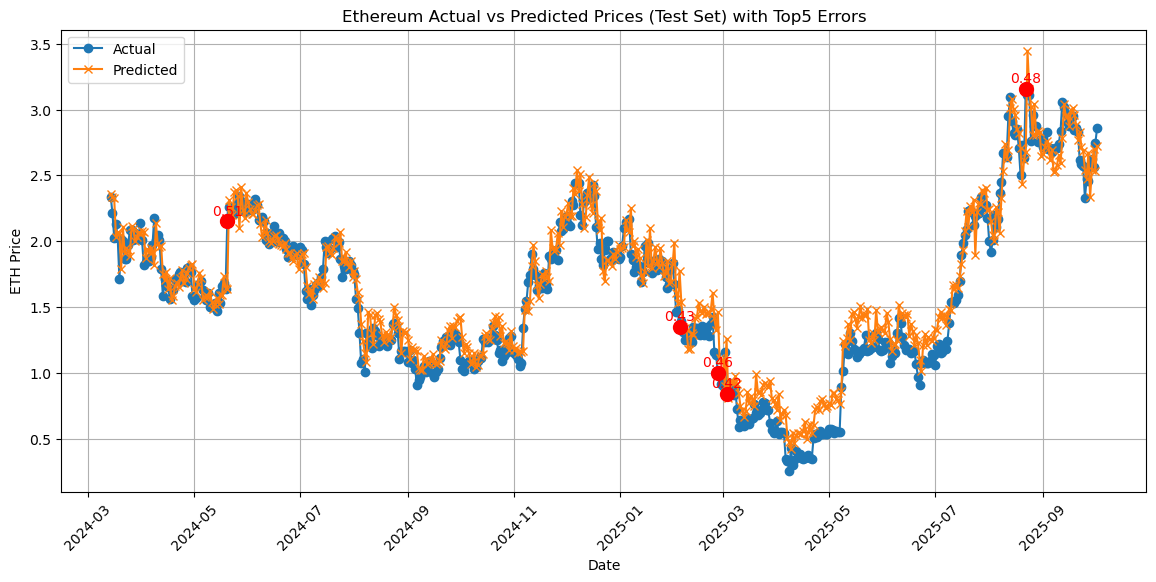

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 테스트 구간 날짜
dates = test_data.index[SEQ_LENGTH:]

# 실제값과 예측값
actual = y_test_actual
predicted = y_pred
errors = np.abs(actual - predicted)

# 데이터프레임 생성
error_df = pd.DataFrame({
    'Date': dates,
    'Actual': actual,
    'Predicted': predicted,
    'Absolute_Error': errors
})

# 오차 기준 TOP 5
top5_errors = error_df.nlargest(5, 'Absolute_Error')
print("=== 테스트 구간 오차 TOP 5 ===")
print(top5_errors)

# 그래프: 실제 vs 예측 + TOP5 표시
plt.figure(figsize=(14,6))
plt.plot(dates, actual, label='Actual', marker='o')
plt.plot(dates, predicted, label='Predicted', marker='x')

# TOP5 날짜 강조
for idx, row in top5_errors.iterrows():
    plt.scatter(row['Date'], row['Actual'], color='red', s=100, zorder=5)
    plt.text(row['Date'], row['Actual']+0.05, f"{row['Absolute_Error']:.2f}", 
             color='red', ha='center')

plt.title('Ethereum Actual vs Predicted Prices (Test Set) with Top5 Errors')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [100]:
############################    온체인 + 기술적 지표  (추세만) #########################################################

def calculate_technical_indicators(df, price_col='Close'):
    """논문 Section III-A의 7개 기술적 지표"""
    df = df.copy()
    
    N = 14
    low_14 = df[price_col].rolling(window=N).min()
    high_14 = df[price_col].rolling(window=N).max()
    df['stochastic_k'] = ((df[price_col] - low_14) / (high_14 - low_14)) * 100
    df['stochastic_d'] = df['stochastic_k'].rolling(window=3).mean()
    df['williams_r'] = ((high_14 - df[price_col]) / (high_14 - low_14)) * 100
    df['ad_oscillator'] = (df[price_col] - df[price_col].shift(1)) / (df['High'] - df['Low'])
    df['momentum'] = df[price_col] - df[price_col].shift(10)
    
    ma_7 = df[price_col].rolling(window=7).mean()
    df['disparity_7'] = (df[price_col] / ma_7) * 100
    df['roc'] = (df[price_col] / df[price_col].shift(12)) * 100
    
    return df

# ETH에만 기술적 지표 추가 (논문: 타겟 암호화폐만)
eth_with_indicators = calculate_technical_indicators(eth_price)
print("\n기술적 지표 계산 완료")
print(eth_with_indicators.columns.tolist())

# ============================================
# 3. 데이터 병합
# ============================================

eth_full = eth_with_indicators.copy()

# BTC 데이터 병합 (기술적 지표 없이 가격 5개만)
eth_full = eth_full.join(btc, how='left')

# Onchain 데이터 병합
eth_full = eth_full.join(onchain, how='left')

# 결측치 제거
eth_full = eth_full.dropna()

print("\n최종 데이터 형태:", eth_full.shape)
print("데이터 기간:", eth_full.index.min(), "~", eth_full.index.max())
print("\n컬럼 목록:")
print(eth_full.columns.tolist())

# ============================================
# 4. 데이터셋 생성 (논문 Section II)
# ============================================

def create_sequences(data, seq_length=7):
    """
    논문의 L=7일 관측 윈도우
    xg: opening, closing, high, low, volume + 7 technical indicators (12개)
    xm: BTC opening, closing, high, low, volume (5개)
    """
    target_features = ['Open', 'Close', 'High', 'Low', 'Volume',
                       'stochastic_k', 'stochastic_d', 'williams_r', 
                       'ad_oscillator', 'momentum', 'disparity_7', 'roc']
    
    macro_features = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
    #sentiment_features = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']
    
    xg_list, xm_list, sentiment_list, y_list = [], [], [], []
    
    for i in range(seq_length, len(data)):
        xg_list.append(data[target_features].iloc[i-seq_length:i].values)
        xm_list.append(data[macro_features].iloc[i-seq_length:i].values)
        #sentiment_list.append(data[sentiment_features].iloc[i-seq_length:i].values)
        y_list.append(data['Close'].iloc[i])
    
    return (np.array(xg_list), np.array(xm_list), np.array(y_list))

# 데이터 분할 (7:1:2)
total_len = len(eth_full)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.1)

train_data = eth_full.iloc[:train_size].copy()
val_data = eth_full.iloc[train_size:train_size+val_size].copy()
test_data = eth_full.iloc[train_size+val_size:].copy()

print(f"\n데이터 분할:")
print(f"Train: {len(train_data)} ({train_data.index.min()} ~ {train_data.index.max()})")
print(f"Val: {len(val_data)} ({val_data.index.min()} ~ {val_data.index.max()})")
print(f"Test: {len(test_data)} ({test_data.index.min()} ~ {test_data.index.max()})")

# 정규화
scaler_target = StandardScaler()
scaler_macro = StandardScaler()
scaler_sentiment = StandardScaler()
scaler_y = StandardScaler()

target_cols = ['Open', 'Close', 'High', 'Low', 'Volume',
               'stochastic_k', 'stochastic_d', 'williams_r', 
               'ad_oscillator', 'momentum', 'disparity_7', 'roc']
macro_cols = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
#sentiment_cols = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']

train_data[target_cols] = scaler_target.fit_transform(train_data[target_cols])
train_data[macro_cols] = scaler_macro.fit_transform(train_data[macro_cols])
#train_data[sentiment_cols] = scaler_sentiment.fit_transform(train_data[sentiment_cols])

val_data[target_cols] = scaler_target.transform(val_data[target_cols])
val_data[macro_cols] = scaler_macro.transform(val_data[macro_cols])
#val_data[sentiment_cols] = scaler_sentiment.transform(val_data[sentiment_cols])

test_data[target_cols] = scaler_target.transform(test_data[target_cols])
test_data[macro_cols] = scaler_macro.transform(test_data[macro_cols])
#test_data[sentiment_cols] = scaler_sentiment.transform(test_data[sentiment_cols])

# 시퀀스 생성
SEQ_LENGTH = 7

X_train_g, X_train_m, y_train = create_sequences(train_data, SEQ_LENGTH)
X_val_g, X_val_m, y_val = create_sequences(val_data, SEQ_LENGTH)
X_test_g, X_test_m, y_test = create_sequences(test_data, SEQ_LENGTH)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"\n시퀀스 생성 완료:")
print(f"X_train_g: {X_train_g.shape}, X_train_m: {X_train_m.shape}, X_train_s: {X_train_s.shape}")

# ============================================
# 5. CryptoPulse 모델 (논문 Section III)
# ============================================

class PositionalEncoding(layers.Layer):
    """논문 Section III-B: Sinusoidal Positional Encoding"""
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        position = tf.cast(tf.range(seq_length), dtype=tf.float32)
        position = tf.reshape(position, [-1, 1])
        
        dim_indices = tf.cast(tf.range(0, self.d_model, 2), dtype=tf.float32)
        div_term = tf.exp(dim_indices * -(tf.math.log(10000.0) / self.d_model))
        div_term = tf.reshape(div_term, [1, -1])
        
        angle = position * div_term
        pe_sin = tf.sin(angle)
        pe_cos = tf.cos(angle)
        
        pe_list = []
        for i in range(self.d_model):
            if i % 2 == 0:
                pe_list.append(pe_sin[:, i // 2])
            else:
                pe_list.append(pe_cos[:, i // 2])
        
        pe = tf.stack(pe_list, axis=1)
        pe = tf.expand_dims(pe, 0)
        
        return inputs + pe
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

class PeriodAttention(layers.Layer):
    """논문 Section III-B: Period-based Attention with Roll"""
    def __init__(self, d_model, **kwargs):
        super(PeriodAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
    
    def call(self, query, key_value):
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        
        Q = self.query_dense(query)
        
        rolled_keys = []
        rolled_values = []
        
        for tau in range(7):  # seq_len=7 고정
            rolled = tf.roll(key_value, shift=tau, axis=1)
            K = self.key_dense(rolled)
            V = self.value_dense(rolled)
            rolled_keys.append(K)
            rolled_values.append(V)
        
        K_stack = tf.stack(rolled_keys, axis=1)
        V_stack = tf.stack(rolled_values, axis=1)
        
        Q_expanded = tf.expand_dims(Q, axis=1)
        scores = tf.reduce_sum(Q_expanded * K_stack, axis=-1)
        scores = scores / tf.sqrt(tf.cast(self.d_model, tf.float32))
        
        attention_weights = tf.nn.softmax(scores, axis=1)
        attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
        output = tf.reduce_sum(attention_weights_expanded * V_stack, axis=1)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

def build_cryptopulse_model(seq_length=7, n_target_features=12, n_macro_features=5, d_model=64, dropout_rate=0.1):

    
    """감성 분석 없이 CryptoPulse 모델"""
    
    input_xg = layers.Input(shape=(seq_length, n_target_features), name='target_crypto')
    input_xm = layers.Input(shape=(seq_length, n_macro_features), name='macro_env')
    
    # Target Crypto Embedding
    xg_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xg)
    xg_emb = PositionalEncoding(d_model)(xg_conv)
    xg_emb = layers.Dropout(dropout_rate)(xg_emb)

    # Macro Embedding
    xm_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xm)
    xm_emb = PositionalEncoding(d_model)(xm_conv)
    xm_emb = layers.Dropout(dropout_rate)(xm_emb)

    # Period Attention
    hm = PeriodAttention(d_model)(xg_emb, xm_emb)

    # Feedforward for Macro Dynamics
    hm_ff = layers.Dense(d_model, activation='relu')(hm)
    hm_ff = layers.Dropout(dropout_rate)(hm_ff)
    
    hm_transposed = tf.transpose(hm_ff, perm=[0, 2, 1])
    hm_temp = layers.Dense(seq_length, activation='relu')(hm_transposed)
    hm_temp = tf.transpose(hm_temp, perm=[0, 2, 1])
    hm_feat = layers.Dense(d_model // 2, activation='relu')(hm_temp)
    hm_flat = layers.Flatten()(hm_feat)
    delta_macro = layers.Dense(1, name='delta_macro')(hm_flat)

    # NLinear Dynamics
    last_close_idx = 1
    last_close = input_xg[:, -1:, last_close_idx:last_close_idx+1]
    last_close = tf.tile(last_close, [1, seq_length, n_target_features])
    xg_normalized = input_xg - last_close

    xg_flat = layers.Flatten()(xg_normalized)
    xg_linear = layers.Dense(128, activation='relu')(xg_flat)
    xg_linear = layers.Dropout(dropout_rate)(xg_linear)
    xg_linear = layers.Dense(64, activation='relu')(xg_linear)
    delta_dynamics = layers.Dense(1, name='delta_dynamics')(xg_linear)

    # 최종 예측 (간단히 평균)
    final_pred = (delta_macro + delta_dynamics) / 2

    model = Model(
        inputs=[input_xg, input_xm],
        outputs=final_pred,
        name='CryptoPulse_no_sentiment'
    )
    
    return model

model = build_cryptopulse_model(
    seq_length=SEQ_LENGTH,
    n_target_features=12,
    n_macro_features=5,
    d_model=64,
    dropout_rate=0.1
)

model.summary()

# ============================================
# 6. 학습 (논문 Section III-D)
# ============================================

initial_lr = 0.0005

model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss='mse',
    metrics=['mae']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\n========== 모델 학습 시작 ==========")
history = model.fit(
    [X_train_g, X_train_m],
    y_train_scaled,
    validation_data=([X_val_g, X_val_m], y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ============================================
# 7. 평가 (논문 Section IV-B)
# ============================================

def calculate_corr(y_true, y_pred):
    """논문 Equation 13: CORR 메트릭"""
    numerator = np.sum(y_true * y_pred)
    denominator = np.sqrt(np.sum(y_true**2) * np.sum(y_pred**2))
    if denominator == 0:
        return 0
    return numerator / denominator

y_pred_scaled = model.predict([X_test_g, X_test_m])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = y_test

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
corr = calculate_corr(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\n========== Ethereum 테스트 결과  ==========")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"CORR: {corr:.4f}")
print(f"R^2: {r2:.4f}")

results_df = pd.DataFrame({
    'Date': test_data.index[SEQ_LENGTH:],
    'Actual': y_test_actual,
    'Predicted': y_pred
})

print("\n예측 샘플 (최근 10개):")
print(results_df.tail(10))

model.save('cryptopulse_eth_model.h5')
print("\n모델 저장 완료: cryptopulse_eth_model.h5")


기술적 지표 계산 완료
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc']

최종 데이터 형태: (2870, 27)
데이터 기간: 2017-11-24 00:00:00 ~ 2025-10-02 00:00:00

컬럼 목록:
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Open', 'btc_Volume', 'tx_count', 'active_addresses', 'new_addresses', 'large_eth_transfers', 'token_transfers', 'contract_events', 'avg_gas_price', 'total_gas_used', 'avg_block_size', 'avg_block_difficulty']

데이터 분할:
Train: 2008 (2017-11-24 00:00:00 ~ 2023-05-24 00:00:00)
Val: 287 (2023-05-25 00:00:00 ~ 2024-03-06 00:00:00)
Test: 575 (2024-03-07 00:00:00 ~ 2025-10-02 00:00:00)

시퀀스 생성 완료:
X_train_g: (2001, 7, 12), X_train_m: (2001, 7, 5), X_train_s: (2001, 7, 3)
Model: "CryptoPulse_no_sentiment"
___________________________________________________________________________________


========== 모델 학습 시작 ==========
Epoch 1/100
63/63 [==============================] - 6s 37ms/step - loss: 0.1203 - mae: 0.2227 - val_loss: 0.0130 - val_mae: 0.0898 - lr: 5.0000e-04
Epoch 2/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0231 - mae: 0.1126 - val_loss: 0.0068 - val_mae: 0.0645 - lr: 5.0000e-04
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 0.0175 - mae: 0.0996 - val_loss: 0.0139 - val_mae: 0.1013 - lr: 5.0000e-04
Epoch 4/100
63/63 [==============================] - 1s 12ms/step - loss: 0.0167 - mae: 0.0958 - val_loss: 0.0056 - val_mae: 0.0600 - lr: 5.0000e-04
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0144 - mae: 0.0883 - val_loss: 0.0044 - val_mae: 0.0524 - lr: 5.0000e-04
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0131 - mae: 0.0838 - val_loss: 0.0039 - val_mae: 0.0480 - lr: 5.0000e-04
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: 

Sign Accuracy: 0.4744
R² Score: 0.9448


In [110]:
############################    온체인 + 기술적 지표  (방향 + 가격 통합) #########################################################

def calculate_technical_indicators(df, price_col='Close'):
    """논문 Section III-A의 7개 기술적 지표"""
    df = df.copy()
    
    N = 14
    low_14 = df[price_col].rolling(window=N).min()
    high_14 = df[price_col].rolling(window=N).max()
    df['stochastic_k'] = ((df[price_col] - low_14) / (high_14 - low_14)) * 100
    df['stochastic_d'] = df['stochastic_k'].rolling(window=3).mean()
    df['williams_r'] = ((high_14 - df[price_col]) / (high_14 - low_14)) * 100
    df['ad_oscillator'] = (df[price_col] - df[price_col].shift(1)) / (df['High'] - df['Low'])
    df['momentum'] = df[price_col] - df[price_col].shift(10)
    
    ma_7 = df[price_col].rolling(window=7).mean()
    df['disparity_7'] = (df[price_col] / ma_7) * 100
    df['roc'] = (df[price_col] / df[price_col].shift(12)) * 100
    
    return df

# ETH에만 기술적 지표 추가 (논문: 타겟 암호화폐만)
eth_with_indicators = calculate_technical_indicators(eth_price)
print("\n기술적 지표 계산 완료")
print(eth_with_indicators.columns.tolist())

# ============================================
# 3. 데이터 병합
# ============================================

eth_full = eth_with_indicators.copy()

# BTC 데이터 병합 (기술적 지표 없이 가격 5개만)
eth_full = eth_full.join(btc, how='left')

# Onchain 데이터 병합
eth_full = eth_full.join(onchain, how='left')

# 결측치 제거
eth_full = eth_full.dropna()

print("\n최종 데이터 형태:", eth_full.shape)
print("데이터 기간:", eth_full.index.min(), "~", eth_full.index.max())
print("\n컬럼 목록:")
print(eth_full.columns.tolist())

# ============================================
# 4. 데이터셋 생성 (논문 Section II)
# ============================================

def create_sequences(data, seq_length=7):
    """
    논문의 L=7일 관측 윈도우
    xg: opening, closing, high, low, volume + 7 technical indicators (12개)
    xm: BTC opening, closing, high, low, volume (5개)
    """
    target_features = ['Open', 'Close', 'High', 'Low', 'Volume',
                       'stochastic_k', 'stochastic_d', 'williams_r', 
                       'ad_oscillator', 'momentum', 'disparity_7', 'roc']
    
    macro_features = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
    #sentiment_features = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']
    
    xg_list, xm_list, sentiment_list, y_list = [], [], [], []
    
    for i in range(seq_length, len(data)):
        xg_list.append(data[target_features].iloc[i-seq_length:i].values)
        xm_list.append(data[macro_features].iloc[i-seq_length:i].values)
        #sentiment_list.append(data[sentiment_features].iloc[i-seq_length:i].values)
        y_list.append(data['Close'].iloc[i])
    
    return (np.array(xg_list), np.array(xm_list), np.array(y_list))

# 데이터 분할 (7:1:2)
total_len = len(eth_full)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.1)

train_data = eth_full.iloc[:train_size].copy()
val_data = eth_full.iloc[train_size:train_size+val_size].copy()
test_data = eth_full.iloc[train_size+val_size:].copy()

print(f"\n데이터 분할:")
print(f"Train: {len(train_data)} ({train_data.index.min()} ~ {train_data.index.max()})")
print(f"Val: {len(val_data)} ({val_data.index.min()} ~ {val_data.index.max()})")
print(f"Test: {len(test_data)} ({test_data.index.min()} ~ {test_data.index.max()})")

# 정규화
scaler_target = StandardScaler()
scaler_macro = StandardScaler()
scaler_sentiment = StandardScaler()
scaler_y = StandardScaler()

target_cols = ['Open', 'Close', 'High', 'Low', 'Volume',
               'stochastic_k', 'stochastic_d', 'williams_r', 
               'ad_oscillator', 'momentum', 'disparity_7', 'roc']
macro_cols = ['btc_Open', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Volume']
#sentiment_cols = ['sentiment_mean', 'sentiment_pos_ratio', 'sentiment_neg_ratio']

train_data[target_cols] = scaler_target.fit_transform(train_data[target_cols])
train_data[macro_cols] = scaler_macro.fit_transform(train_data[macro_cols])
#train_data[sentiment_cols] = scaler_sentiment.fit_transform(train_data[sentiment_cols])

val_data[target_cols] = scaler_target.transform(val_data[target_cols])
val_data[macro_cols] = scaler_macro.transform(val_data[macro_cols])
#val_data[sentiment_cols] = scaler_sentiment.transform(val_data[sentiment_cols])

test_data[target_cols] = scaler_target.transform(test_data[target_cols])
test_data[macro_cols] = scaler_macro.transform(test_data[macro_cols])
#test_data[sentiment_cols] = scaler_sentiment.transform(test_data[sentiment_cols])

# 시퀀스 생성
SEQ_LENGTH = 7

X_train_g, X_train_m, y_train = create_sequences(train_data, SEQ_LENGTH)
X_val_g, X_val_m, y_val = create_sequences(val_data, SEQ_LENGTH)
X_test_g, X_test_m, y_test = create_sequences(test_data, SEQ_LENGTH)

# 이 아래에 추가
y_train_dir = (y_train > X_train_g[:, -1, 1]).astype(int)
delta_threshold = 0.001  # 0.1% 이상 변동만 포함
y_train_dir = ((y_train - X_train_g[:, -1, 1]) > delta_threshold).astype(int)
y_val_dir = (y_val > X_val_g[:, -1, 1]).astype(int)
y_test_dir = (y_test > X_test_g[:, -1, 1]).astype(int)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


print(f"\n시퀀스 생성 완료:")
print(f"X_train_g: {X_train_g.shape}, X_train_m: {X_train_m.shape}")

# ============================================
# 5. CryptoPulse 모델 (논문 Section III)
# ============================================

class PositionalEncoding(layers.Layer):
    """논문 Section III-B: Sinusoidal Positional Encoding"""
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        position = tf.cast(tf.range(seq_length), dtype=tf.float32)
        position = tf.reshape(position, [-1, 1])
        
        dim_indices = tf.cast(tf.range(0, self.d_model, 2), dtype=tf.float32)
        div_term = tf.exp(dim_indices * -(tf.math.log(10000.0) / self.d_model))
        div_term = tf.reshape(div_term, [1, -1])
        
        angle = position * div_term
        pe_sin = tf.sin(angle)
        pe_cos = tf.cos(angle)
        
        pe_list = []
        for i in range(self.d_model):
            if i % 2 == 0:
                pe_list.append(pe_sin[:, i // 2])
            else:
                pe_list.append(pe_cos[:, i // 2])
        
        pe = tf.stack(pe_list, axis=1)
        pe = tf.expand_dims(pe, 0)
        
        return inputs + pe
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

class PeriodAttention(layers.Layer):
    """논문 Section III-B: Period-based Attention with Roll"""
    def __init__(self, d_model, **kwargs):
        super(PeriodAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
    
    def call(self, query, key_value):
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        
        Q = self.query_dense(query)
        
        rolled_keys = []
        rolled_values = []
        
        for tau in range(7):  # seq_len=7 고정
            rolled = tf.roll(key_value, shift=tau, axis=1)
            K = self.key_dense(rolled)
            V = self.value_dense(rolled)
            rolled_keys.append(K)
            rolled_values.append(V)
        
        K_stack = tf.stack(rolled_keys, axis=1)
        V_stack = tf.stack(rolled_values, axis=1)
        
        Q_expanded = tf.expand_dims(Q, axis=1)
        scores = tf.reduce_sum(Q_expanded * K_stack, axis=-1)
        scores = scores / tf.sqrt(tf.cast(self.d_model, tf.float32))
        
        attention_weights = tf.nn.softmax(scores, axis=1)
        attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
        output = tf.reduce_sum(attention_weights_expanded * V_stack, axis=1)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

def build_cryptopulse_model(seq_length=7, n_target_features=12, n_macro_features=5, d_model=64, dropout_rate=0.1):
    """감성 분석 제거 + 가격 예측 + 방향 분류 멀티태스크 모델"""

    input_xg = layers.Input(shape=(seq_length, n_target_features), name='target_crypto')
    input_xm = layers.Input(shape=(seq_length, n_macro_features), name='macro_env')

    # Target Crypto Embedding
    xg_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xg)
    xg_emb = PositionalEncoding(d_model)(xg_conv)
    xg_emb = layers.Dropout(dropout_rate)(xg_emb)

    # Macro Embedding
    xm_conv = layers.Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(input_xm)
    xm_emb = PositionalEncoding(d_model)(xm_conv)
    xm_emb = layers.Dropout(dropout_rate)(xm_emb)

    # Period Attention
    hm = PeriodAttention(d_model)(xg_emb, xm_emb)

    # Feedforward for Macro Dynamics
    hm_ff = layers.Dense(d_model, activation='relu')(hm)
    hm_ff = layers.Dropout(dropout_rate)(hm_ff)

    hm_transposed = tf.transpose(hm_ff, perm=[0, 2, 1])
    hm_temp = layers.Dense(seq_length, activation='relu')(hm_transposed)
    hm_temp = tf.transpose(hm_temp, perm=[0, 2, 1])
    hm_feat = layers.Dense(d_model // 2, activation='relu')(hm_temp)
    hm_flat = layers.Flatten()(hm_feat)
    delta_macro = layers.Dense(1, name='delta_macro')(hm_flat)

    # NLinear Dynamics
    last_close_idx = 1
    last_close = input_xg[:, -1:, last_close_idx:last_close_idx+1]
    last_close = tf.tile(last_close, [1, seq_length, n_target_features])
    xg_normalized = input_xg - last_close

    xg_flat = layers.Flatten()(xg_normalized)
    xg_linear = layers.Dense(128, activation='relu')(xg_flat)
    xg_linear = layers.Dropout(dropout_rate)(xg_linear)
    xg_linear = layers.Dense(64, activation='relu')(xg_linear)
    delta_dynamics = layers.Dense(1, name='delta_dynamics')(xg_linear)

    # 가격 예측 (평균)
    final_pred = (delta_macro + delta_dynamics) / 2

    # 방향 예측 (분류)
    direction_logits = layers.Dense(1, activation='sigmoid', name='direction')(xg_linear)

    model = Model(
        inputs=[input_xg, input_xm],
        outputs={'price': final_pred, 'direction': direction_logits},
        name='CryptoPulse_Multitask'
    )

    return model


# 모델 생성
model = build_cryptopulse_model(
    seq_length=SEQ_LENGTH,
    n_target_features=12,
    n_macro_features=5,
    d_model=64,
    dropout_rate=0.1
)

model.summary()

# 컴파일
initial_lr = 0.0005

model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss={
        'price': 'mse',
        'direction': 'binary_crossentropy'
    },
    loss_weights={'price':0.3,'direction':0.7},
    metrics={
        'price': ['mae'],
        'direction': ['accuracy']
    }
)

# 콜백
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 학습
print("\n========== 모델 학습 시작 ==========")
history = model.fit(
    [X_train_g, X_train_m],
    {'price': y_train_scaled, 'direction': y_train_dir},
    validation_data=(
        [X_val_g, X_val_m],
        {'price': y_val_scaled, 'direction': y_val_dir}
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)


# 평가
def calculate_corr(y_true, y_pred):
    numerator = np.sum(y_true * y_pred)
    denominator = np.sqrt(np.sum(y_true**2) * np.sum(y_pred**2))
    if denominator == 0:
        return 0
    return numerator / denominator

# 예측
preds = model.predict([X_test_g, X_test_m])
y_pred_price = scaler_y.inverse_transform(preds['price'].reshape(-1, 1)).flatten()
y_pred_dir = (preds['direction'].flatten() > 0.5).astype(int)

# 실제
y_test_actual = y_test
y_true_dir = (y_test_actual > X_test_g[:, -1, 1]).astype(int)

# 회귀 평가
mae = mean_absolute_error(y_test_actual, y_pred_price)
mse = mean_squared_error(y_test_actual, y_pred_price)
corr = calculate_corr(y_test_actual, y_pred_price)
r2 = r2_score(y_test_actual, y_pred_price)

# 분류 평가
sign_acc = (y_pred_dir == y_true_dir).mean()

print("\n========== Ethereum 테스트 결과 ==========")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"CORR: {corr:.4f}")
print(f"R^2:  {r2:.4f}")
print(f"Sign Accuracy: {sign_acc:.4f}")

# 결과 출력
results_df = pd.DataFrame({
    'Date': test_data.index[SEQ_LENGTH:],
    'Actual': y_test_actual,
    'Predicted': y_pred_price,
    'Predicted_Direction': y_pred_dir,
    'Actual_Direction': y_true_dir
})

print("\n예측 샘플 (최근 10개):")
print(results_df.tail(10))

# 저장
model.save('cryptopulse_eth_multitask.h5')
print("\n모델 저장 완료: cryptopulse_eth_multitask.h5")



기술적 지표 계산 완료
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc']

최종 데이터 형태: (2870, 27)
데이터 기간: 2017-11-24 00:00:00 ~ 2025-10-02 00:00:00

컬럼 목록:
['Close', 'High', 'Low', 'Open', 'Volume', 'stochastic_k', 'stochastic_d', 'williams_r', 'ad_oscillator', 'momentum', 'disparity_7', 'roc', 'btc_Close', 'btc_High', 'btc_Low', 'btc_Open', 'btc_Volume', 'tx_count', 'active_addresses', 'new_addresses', 'large_eth_transfers', 'token_transfers', 'contract_events', 'avg_gas_price', 'total_gas_used', 'avg_block_size', 'avg_block_difficulty']

데이터 분할:
Train: 2008 (2017-11-24 00:00:00 ~ 2023-05-24 00:00:00)
Val: 287 (2023-05-25 00:00:00 ~ 2024-03-06 00:00:00)
Test: 575 (2024-03-07 00:00:00 ~ 2025-10-02 00:00:00)

시퀀스 생성 완료:
X_train_g: (2001, 7, 12), X_train_m: (2001, 7, 5)
Model: "CryptoPulse_Multitask"
__________________________________________________________________________________________________
 Layer (type

Total params: 41659 (162.73 KB)
Trainable params: 41659 (162.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________

========== 모델 학습 시작 ==========
Epoch 1/100
63/63 [==============================] - 5s 25ms/step - loss: 0.5398 - direction_loss: 0.7188 - tf.math.truediv_11_loss: 0.1220 - direction_accuracy: 0.4998 - tf.math.truediv_11_mae: 0.2390 - val_loss: 0.4951 - val_direction_loss: 0.7013 - val_tf.math.truediv_11_loss: 0.0140 - val_direction_accuracy: 0.4964 - val_tf.math.truediv_11_mae: 0.0932 - lr: 5.0000e-04
Epoch 2/100
63/63 [==============================] - 1s 14ms/step - loss: 0.4965 - direction_loss: 0.6952 - tf.math.truediv_11_loss: 0.0328 - direction_accuracy: 0.5362 - tf.math.truediv_11_mae: 0.1381 - val_loss: 0.4941 - val_direction_loss: 0.6975 - val_tf.math.truediv_11_loss: 0.0195 - val_direction_accuracy: 0.4964 - val_tf.math.truediv_11_mae: 0.1148 - lr: 5.0000e-04
Epoch 3/100
63/

Epoch 21/100
63/63 [==============================] - 1s 12ms/step - loss: 0.4349 - direction_loss: 0.6157 - tf.math.truediv_11_loss: 0.0131 - direction_accuracy: 0.6747 - tf.math.truediv_11_mae: 0.0856 - val_loss: 0.4786 - val_direction_loss: 0.6801 - val_tf.math.truediv_11_loss: 0.0085 - val_direction_accuracy: 0.5607 - val_tf.math.truediv_11_mae: 0.0759 - lr: 1.2500e-04
Epoch 22/100
60/63 [===========================>..] - ETA: 0s - loss: 0.4309 - direction_loss: 0.6096 - tf.math.truediv_11_loss: 0.0137 - direction_accuracy: 0.6729 - tf.math.truediv_11_mae: 0.0857
Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 [==============================] - 1s 12ms/step - loss: 0.4321 - direction_loss: 0.6114 - tf.math.truediv_11_loss: 0.0138 - direction_accuracy: 0.6727 - tf.math.truediv_11_mae: 0.0859 - val_loss: 0.4779 - val_direction_loss: 0.6798 - val_tf.math.truediv_11_loss: 0.0067 - val_direction_accuracy: 0.5571 - val_tf.math.truediv_11_mae: 0.0651 - lr


========== 임계점 그리드 서치 (논문 기반) ==========
Reference: Rafi et al. (2023), Hafid et al. (2024)

초기 임계점: 0.10%
Train 클래스 분포: 상승=46.78%

========== 모델 학습 시작 ==========
Epoch 1/100
63/63 [==============================] - 1s 13ms/step - loss: 0.4582 - direction_loss: 0.6472 - tf.math.truediv_9_loss: 0.0174 - direction_accuracy: 0.6292 - tf.math.truediv_9_mae: 0.0994 - val_loss: 0.4819 - val_direction_loss: 0.6837 - val_tf.math.truediv_9_loss: 0.0110 - val_direction_accuracy: 0.5429 - val_tf.math.truediv_9_mae: 0.0828 - lr: 3.9063e-06
Epoch 2/100
63/63 [==============================] - 1s 12ms/step - loss: 0.4554 - direction_loss: 0.6434 - tf.math.truediv_9_loss: 0.0166 - direction_accuracy: 0.6252 - tf.math.truediv_9_mae: 0.0971 - val_loss: 0.4819 - val_direction_loss: 0.6837 - val_tf.math.truediv_9_loss: 0.0111 - val_direction_accuracy: 0.5429 - val_tf.math.truediv_9_mae: 0.0832 - lr: 3.9063e-06
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 0.4573 - direction_l

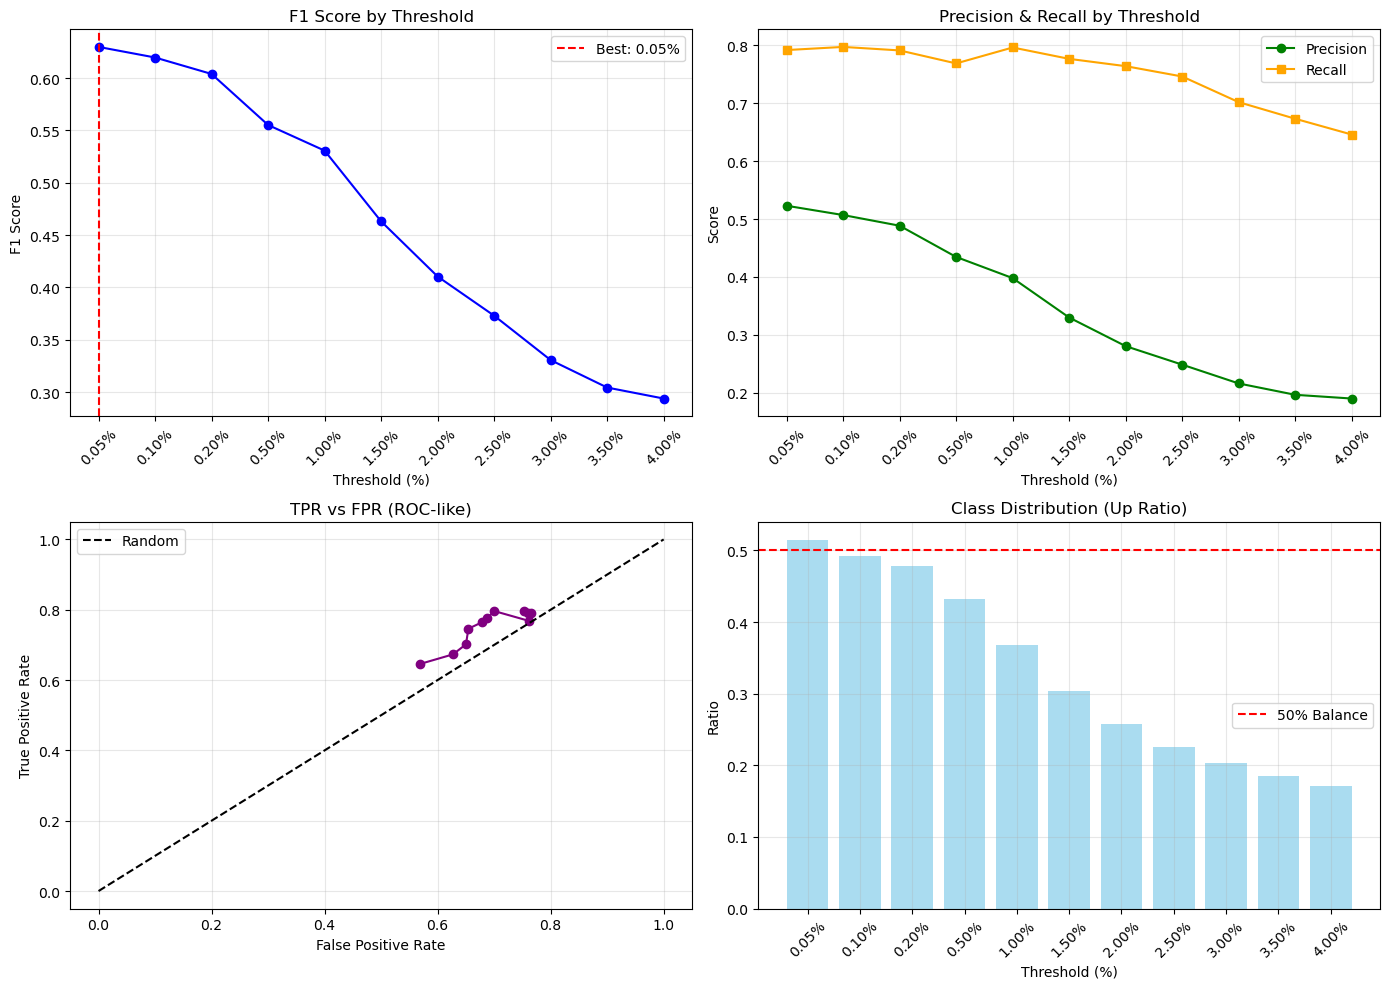

18/18 [==============================] - 0s 6ms/step

========== Ethereum 테스트 결과 (최적 임계점 적용) ==========
최적 임계점: 0.05%
Sign Accuracy: 0.5035
Precision: 0.5060
Recall: 0.8819
F1 Score: 0.6430


In [108]:
from sklearn.metrics import (
    accuracy_score,  
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt

def threshold_grid_search_with_model(model, X_val_g, X_val_m, y_val_scaled, y_val_dir_true, scaler_y, threshold_range):
    """
    논문 기반 임계점 그리드 서치
    
    References:
    - Rafi et al. (2023): CUSUM-based threshold optimization
    - Hafid et al. (2024): Decision threshold tuning for classification
    
    Args:
        model: 학습된 CryptoPulse 모델
        X_val_g, X_val_m: 검증 데이터
        y_val_scaled: 정규화된 실제 가격
        y_val_dir_true: 실제 방향 (기존 방식)
        scaler_y: 가격 스케일러
        threshold_range: 임계점 후보 리스트 (비율)
    
    Returns:
        최적 임계점과 평가 메트릭
    """
    # 모델 예측
    preds = model.predict([X_val_g, X_val_m])
    y_pred_price = scaler_y.inverse_transform(preds['price'].reshape(-1, 1)).flatten()
    last_close_prices = X_val_g[:, -1, 1]  # Close price at t-1
    
    results = {
        'threshold': [],
        'threshold_pct': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'true_positive_rate': [],
        'false_positive_rate': [],
        'class_balance': []
    }
    
    for threshold in threshold_range:
        # 임계점 기반 방향 레이블 생성
        y_pred_dir = ((y_pred_price - last_close_prices) > threshold).astype(int)
        y_true_dir = ((y_val_scaled - last_close_prices) > threshold).astype(int)
        
        # 클래스 분포
        positive_ratio = y_true_dir.mean()
        
        # 평가 지표 계산
        acc = accuracy_score(y_true_dir, y_pred_dir)
        prec = precision_score(y_true_dir, y_pred_dir, zero_division=0)
        rec = recall_score(y_true_dir, y_pred_dir, zero_division=0)
        f1 = f1_score(y_true_dir, y_pred_dir, zero_division=0)
        
        # Confusion Matrix
        tn, fp, fn, tp = confusion_matrix(y_true_dir, y_pred_dir).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        results['threshold'].append(threshold)
        results['threshold_pct'].append(f"{threshold*100:.2f}%")
        results['accuracy'].append(acc)
        results['precision'].append(prec)
        results['recall'].append(rec)
        results['f1_score'].append(f1)
        results['true_positive_rate'].append(tpr)
        results['false_positive_rate'].append(fpr)
        results['class_balance'].append(positive_ratio)
    
    return pd.DataFrame(results)

# 논문 기반 임계점 범위 설정
# Rafi et al. (2023): 0.05% ~ 4% 탐색
# Hafid et al. (2024): 0.1% ~ 2% 최적
threshold_candidates = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

print("\n========== 임계점 그리드 서치 (논문 기반) ==========")
print("Reference: Rafi et al. (2023), Hafid et al. (2024)")

# 임시 방향 레이블 (초기 학습용 - 0.1% threshold 사용)
INITIAL_THRESHOLD = 0.001
y_train_dir = ((y_train - X_train_g[:, -1, 1]) > INITIAL_THRESHOLD).astype(int)
y_val_dir = ((y_val - X_val_g[:, -1, 1]) > INITIAL_THRESHOLD).astype(int)
y_test_dir = ((y_test - X_test_g[:, -1, 1]) > INITIAL_THRESHOLD).astype(int)

print(f"\n초기 임계점: {INITIAL_THRESHOLD*100:.2f}%")
print(f"Train 클래스 분포: 상승={y_train_dir.mean():.2%}")
# 모델 학습 (기존 코드)
print("\n========== 모델 학습 시작 ==========")
history = model.fit(
    [X_train_g, X_train_m],
    {'price': y_train_scaled, 'direction': y_train_dir},
    validation_data=(
        [X_val_g, X_val_m],
        {'price': y_val_scaled, 'direction': y_val_dir}
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ===== 여기에 그리드 서치 추가 =====
print("\n========== 임계점 최적화 (Validation Set) ==========")
grid_results = threshold_grid_search_with_model(
    model, X_val_g, X_val_m, y_val, y_val_dir, scaler_y, threshold_candidates
)

print("\n임계점별 평가 결과:")
print(grid_results[['threshold_pct', 'accuracy', 'precision', 'recall', 'f1_score', 'class_balance']])

# 최적 임계점 선택 (F1 Score 기준)
best_idx = grid_results['f1_score'].idxmax()
OPTIMAL_THRESHOLD = grid_results.loc[best_idx, 'threshold']
optimal_f1 = grid_results.loc[best_idx, 'f1_score']

print(f"\n최적 임계점 (F1 Score 기준): {OPTIMAL_THRESHOLD*100:.2f}%")
print(f"  - F1 Score: {optimal_f1:.4f}")
print(f"  - Accuracy: {grid_results.loc[best_idx, 'accuracy']:.4f}")
print(f"  - Precision: {grid_results.loc[best_idx, 'precision']:.4f}")
print(f"  - Recall: {grid_results.loc[best_idx, 'recall']:.4f}")
print(f"  - Class Balance: {grid_results.loc[best_idx, 'class_balance']:.2%}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# F1 Score
axes[0, 0].plot(grid_results['threshold_pct'], grid_results['f1_score'], marker='o', color='blue')
axes[0, 0].axvline(x=best_idx, color='red', linestyle='--', label=f'Best: {OPTIMAL_THRESHOLD*100:.2f}%')
axes[0, 0].set_title('F1 Score by Threshold')
axes[0, 0].set_xlabel('Threshold (%)')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision vs Recall
axes[0, 1].plot(grid_results['threshold_pct'], grid_results['precision'], marker='o', label='Precision', color='green')
axes[0, 1].plot(grid_results['threshold_pct'], grid_results['recall'], marker='s', label='Recall', color='orange')
axes[0, 1].set_title('Precision & Recall by Threshold')
axes[0, 1].set_xlabel('Threshold (%)')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# ROC-like curve
axes[1, 0].plot(grid_results['false_positive_rate'], grid_results['true_positive_rate'], marker='o', color='purple')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_title('TPR vs FPR (ROC-like)')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Class Balance
axes[1, 1].bar(grid_results['threshold_pct'], grid_results['class_balance'], color='skyblue', alpha=0.7)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', label='50% Balance')
axes[1, 1].set_title('Class Distribution (Up Ratio)')
axes[1, 1].set_xlabel('Threshold (%)')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('threshold_optimization_paper_based.png', dpi=300, bbox_inches='tight')
plt.show()


# 예측 (기존 코드)
preds = model.predict([X_test_g, X_test_m])
y_pred_price = scaler_y.inverse_transform(preds['price'].reshape(-1, 1)).flatten()

# 최적 임계점으로 방향 예측
y_pred_dir = ((y_pred_price - X_test_g[:, -1, 1]) > OPTIMAL_THRESHOLD).astype(int)
y_true_dir = ((y_test - X_test_g[:, -1, 1]) > OPTIMAL_THRESHOLD).astype(int)

# 평가
sign_acc = (y_pred_dir == y_true_dir).mean()

print("\n========== Ethereum 테스트 결과 (최적 임계점 적용) ==========")
print(f"최적 임계점: {OPTIMAL_THRESHOLD*100:.2f}%")
print(f"Sign Accuracy: {sign_acc:.4f}")
print(f"Precision: {precision_score(y_true_dir, y_pred_dir, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_true_dir, y_pred_dir, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_true_dir, y_pred_dir, zero_division=0):.4f}")
